In [2]:
import pandas as pd

df = pd.read_csv('item-demand-time.csv', dtype = object, names=['timestamp','value','item'])
df.head(3)

,timestamp,value,item
0,2014-01-01 01:00:00,38.34991708126038,client_12
1,2014-01-01 02:00:00,33.5820895522388,client_12
2,2014-01-01 03:00:00,34.41127694859037,client_12


In [4]:
df.item.unique()

array(['client_12', 'client_10', 'client_111'], dtype=object)

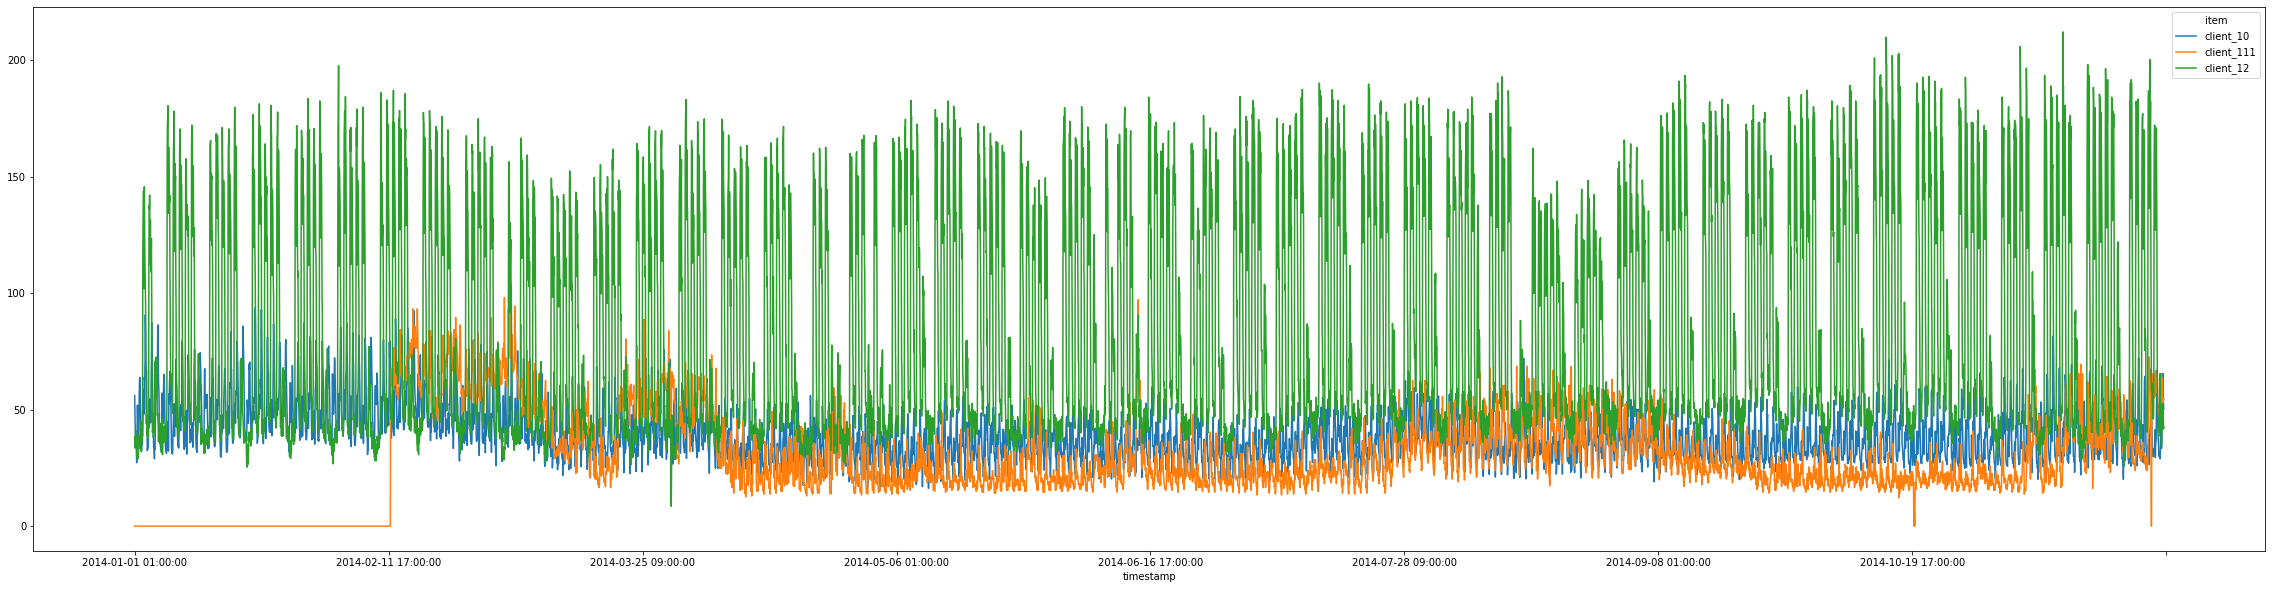

In [5]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

df.value=pd.to_numeric(df.value)
df_plot = df.pivot(index='timestamp', columns='item', values='value')
df_plot.plot(figsize=(40,10))

In [6]:
# RCF can only train a model on a single series. Second, RCF requires integer values.
df = df[df['item']=='client_12']
df = df.drop(['item', 'timestamp'], axis=1)

In [7]:
df.value = df.value.astype('float32')
df.value*=100
df.value = df.value.astype('int32')
df.head(3)

,value
0,3834
1,3358
2,3441


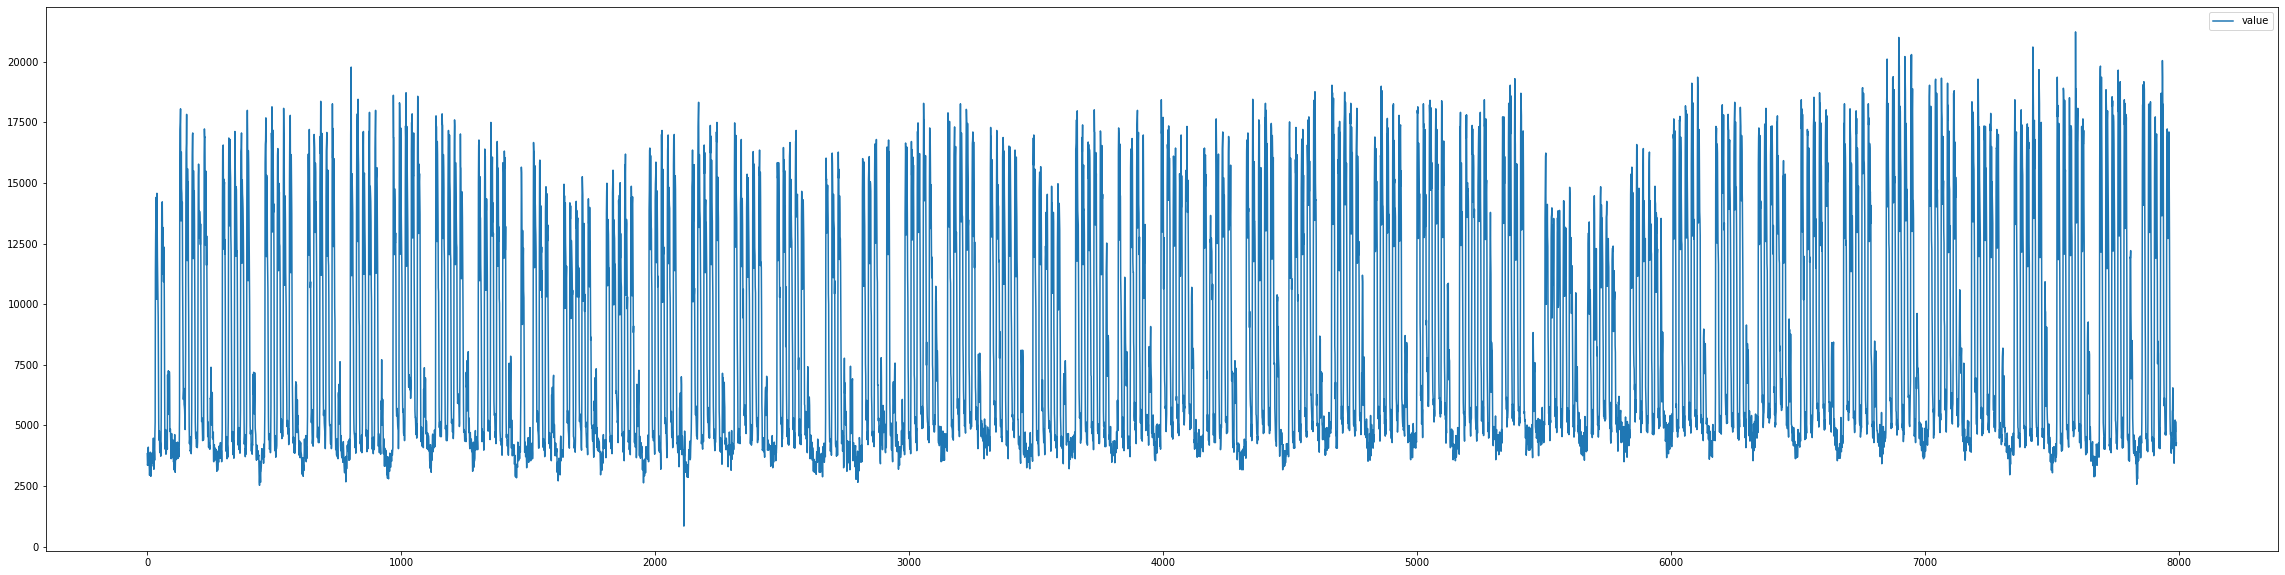

In [8]:
df.plot(figsize=(40,10))

In [9]:
df.to_csv('electricity.csv', index=False, header=False)

In [10]:
import boto3
import sagemaker

print(sagemaker.__version__)

sess = sagemaker.Session()
role = sagemaker.get_execution_role()
bucket = sess.default_bucket()
prefix = 'adeelml-electricity'

training_data_path = sess.upload_data(path='electricity.csv', key_prefix=prefix + '/input/training')
training_data_channel = sagemaker.TrainingInput(s3_data=training_data_path, 
                                           content_type='text/csv;label_size=0',
                                           distribution='ShardedByS3Key')
rcf_data = {'train': training_data_channel}

2.41.0


In [11]:
print(training_data_path)

s3://sagemaker-us-west-1-886035371869/adeelml-electricity/input/training/electricity.csv


In [12]:
import boto3
from sagemaker.estimator import Estimator
from sagemaker import image_uris

region = boto3.Session().region_name    
container = image_uris.retrieve('randomcutforest', region)

rcf_estimator = Estimator(container,
                role=role,
                instance_count=1,
                instance_type='ml.m5.large',
                output_path='s3://{}/{}/output'.format(bucket, prefix))

rcf_estimator.set_hyperparameters(feature_dim=1)

In [13]:
rcf_estimator.fit(rcf_data)

2021-06-19 13:44:03 Starting - Starting the training job...
2021-06-19 13:44:05 Starting - Launching requested ML instancesProfilerReport-1624110243: InProgress
......
2021-06-19 13:45:10 Starting - Preparing the instances for training......
2021-06-19 13:46:34 Downloading - Downloading input data
2021-06-19 13:46:34 Training - Downloading the training image...
2021-06-19 13:47:00 Uploading - Uploading generated training modelDocker entrypoint called with argument(s): train
Running default environment configuration script
[06/19/2021 13:46:57 INFO 139803092948800] Reading default configuration from /opt/amazon/lib/python3.7/site-packages/algorithm/resources/default-conf.json: {'num_samples_per_tree': 256, 'num_trees': 100, 'force_dense': 'true', 'eval_metrics': ['accuracy', 'precision_recall_fscore'], 'epochs': 1, 'mini_batch_size': 1000, '_log_level': 'info', '_kvstore': 'dist_async', '_num_kv_servers': 'auto', '_num_gpus': 'auto', '_tuning_objective_metric': '', '_ftp_port': 8999}
[0

In [14]:
from time import strftime, gmtime
timestamp = strftime('%d-%H-%M-%S', gmtime())

endpoint_name = 'rcf-demo'+'-'+timestamp

rcf_predictor = rcf_estimator.deploy(endpoint_name=endpoint_name, 
                        initial_instance_count=1, 
                        instance_type='ml.t2.medium')

---------------!

In [15]:
rcf_predictor.serializer = sagemaker.serializers.CSVSerializer()
rcf_predictor.deserializer = sagemaker.deserializers.JSONDeserializer()

values = df['value'].astype('str').tolist()
response = rcf_predictor.predict(values)

In [16]:
from statistics import mean,stdev

scores = []
for s in response['scores']:
    scores.append(s['score'])
    
score_mean = mean(scores)
score_std = stdev(scores)

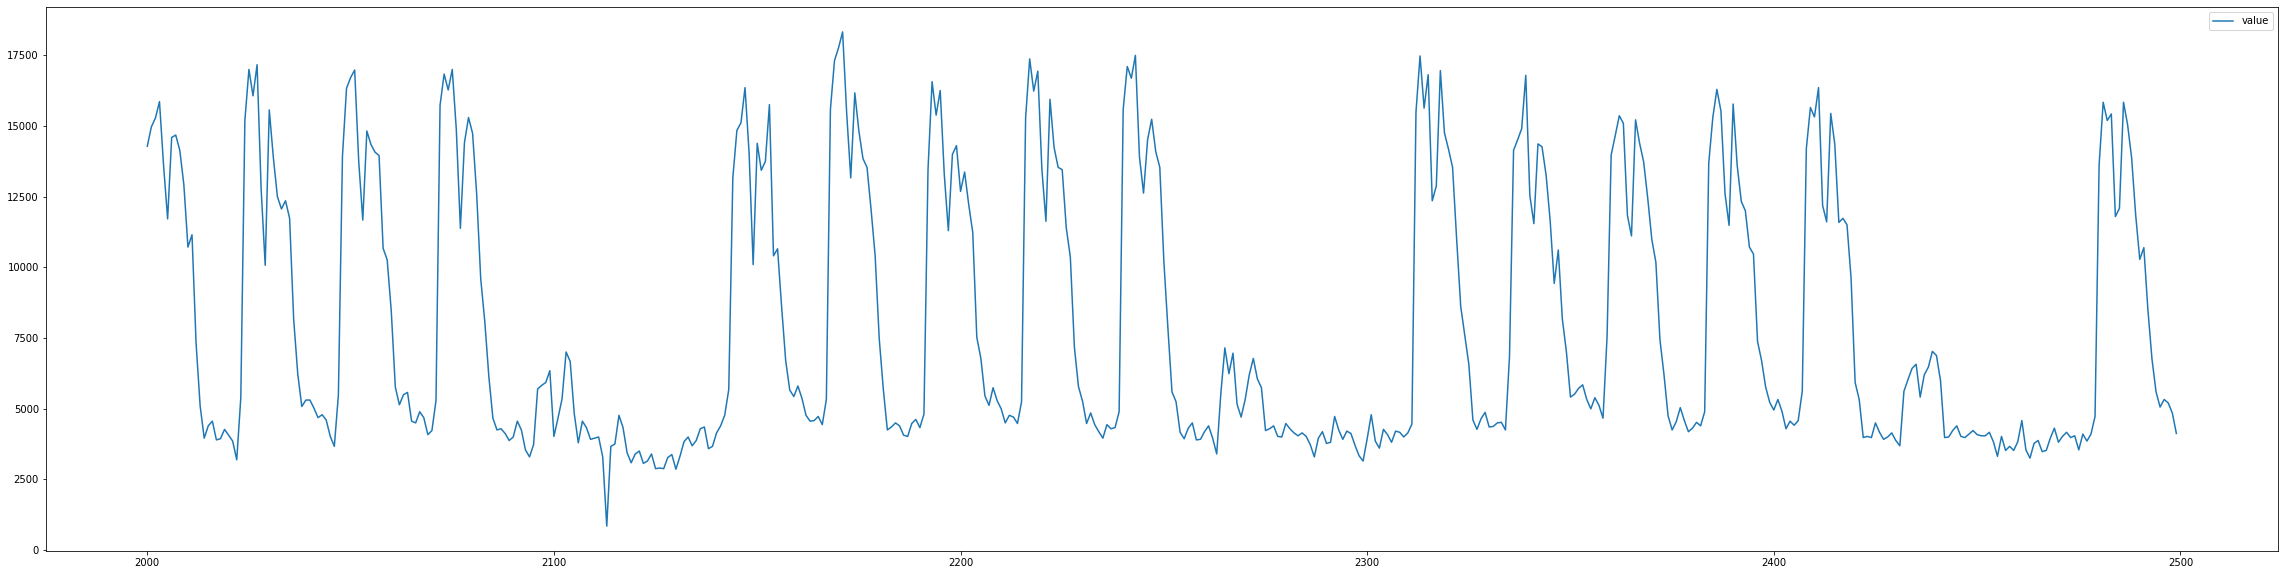

In [25]:
df[2000:2500].plot(figsize=(40,10))

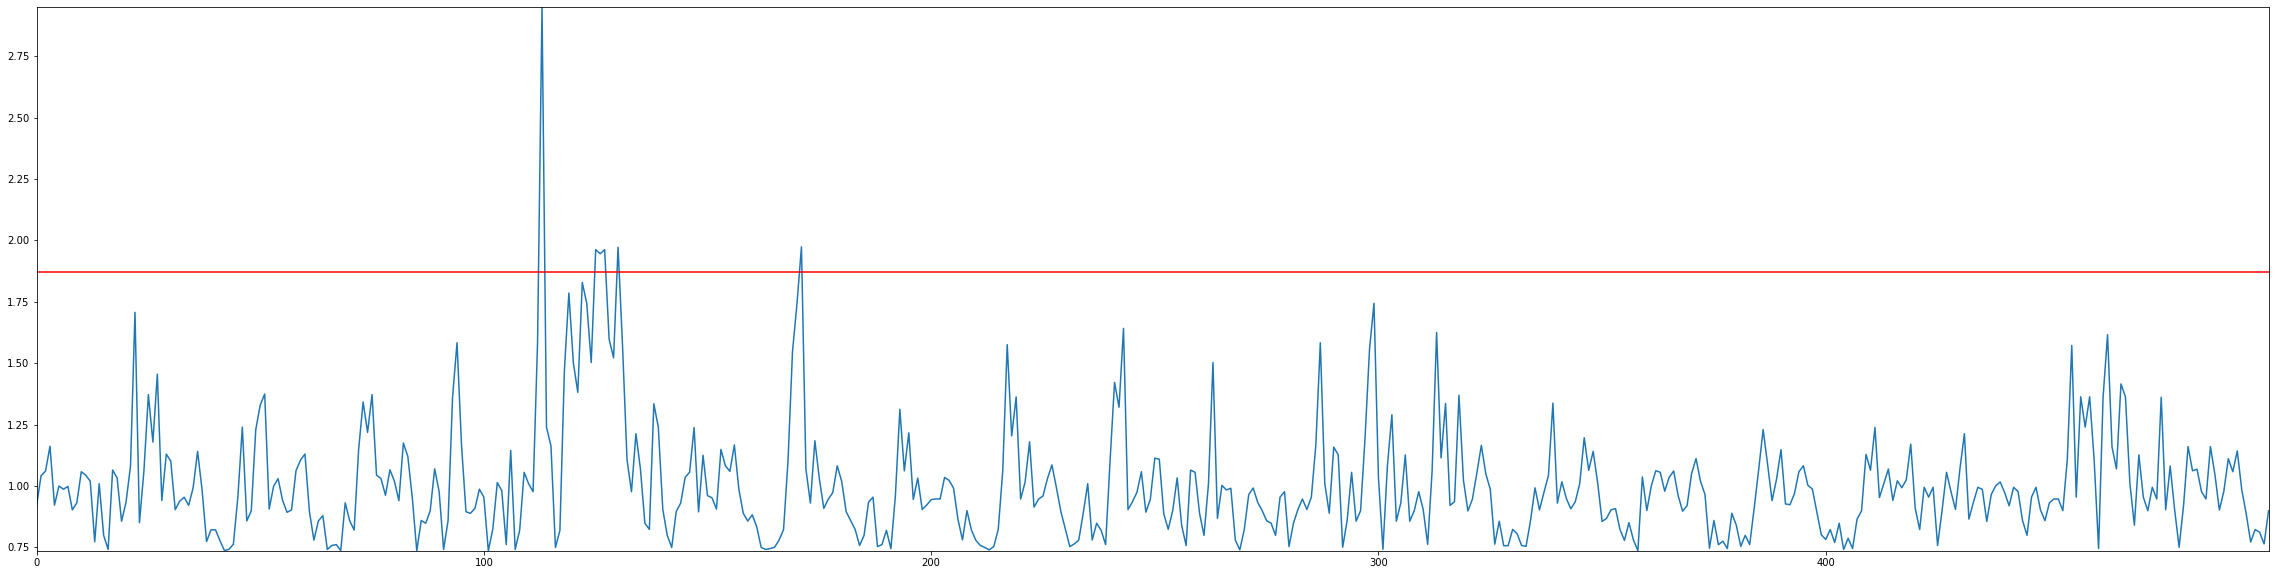

In [26]:
plt.figure(figsize=(40,10))
plt.plot(scores[2000:2500])
plt.autoscale(tight=True)
plt.axhline(y=score_mean+3*score_std, color='red')
plt.show()

In [ ]:
rcf_predictor.delete_endpoint()